# System Identification - FOPDT Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb

import lpfgopt
lpfgopt.__version__

'1.0.1'

## Load Input-Output Dataset

In [2]:
data_dir = 'data'
os.listdir(data_dir)

['io_data_fopdt.csv']

In [3]:
filename = 'io_data_fopdt.csv'
input_output_data = pd.read_csv(os.path.join(data_dir, filename))
input_output_data

,Output,Time,Input1,Input2
0,529.43,5011.92,3.8,950.433
1,529.41,5027.04,3.8,951.558
2,529.36,5042.16,3.8,948.592
3,529.32,5057.28,3.9,947.967
4,529.25,5072.04,3.9,951.153
...,...,...,...,...
876,482.21,18171.00,6.4,933.481
877,480.75,18186.12,6.4,933.328
878,479.00,18201.24,6.4,936.604
879,477.03,18216.00,6.4,935.107


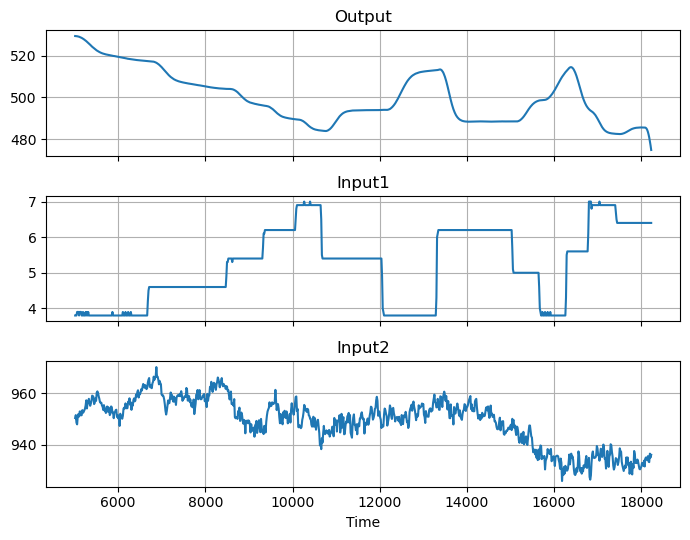

In [4]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 5.5))

data = input_output_data.set_index('Time')

for ax, name in zip(axes, data.columns):
    data[name].plot(ax=ax, grid=True, title=name)

plt.tight_layout()
plt.show()

## Implement Simulation Function

VBA code from Russ

```basic
Ndelay=INT(thetamodel/dt + 0.5)                         ‘discretized model delay
clambda = Exp(-dt / Taumodel)                                             ‘model coefficient
lambda = 1 – clambda                                               ‘complement to model coefficient
ymodeldev = Yinitial – Ybase                                  ‘initial deviation variable value for model
SSD = 0                                                                                          ‘initialize the Sum of Squared Deviations
For DataNumber = Ndelay + 1 To Ndata                            ‘start with first value after the delay
                influence = udata(DataNumber - Ndelay) – Ubase                       ‘calculate influence
                ymodeldev = lambda * Kmodel * influence + clambda * ymodeldev               ‘model
                ymodel(DataNumber) = ymodeldev + Ybase                                  ‘convert to CV
                SSD = SSD + (ymodel(DataNumber) – ydata(DataNumber))^2 ‘sum d^2
Next DataNumber
```

In [5]:
def make_simulate_function(dt, u_data):
    n_data = u_data.shape[0]

    @nb.njit
    def simulate(
        K: float, 
        tau: float, 
        n_delay: int, 
        y_base: float,
        u_base: float, 
        y_init: float 
    ) -> np.ndarray:
        alpha_comp = np.exp(-dt / tau)
        alpha = 1.0 - alpha_comp
        y_dev = y_init - y_base
        y_model = np.full((n_data, ), np.nan)  # Initialize array
        for k in range(n_delay + 1, n_data):
            influence = u_data[k - n_delay] - u_base
            y_dev = alpha * K * influence + alpha_comp * y_dev
            y_model[k] = y_dev + y_base
        return y_model  # Add return statement

    return simulate


def prediction_error(y_model, y_data):
    ssd = np.sum((y_model - y_data) ** 2)
    return ssd


In [6]:
input_col = 'Input1'
t = input_output_data['Time'].to_numpy()
u_data = input_output_data[input_col].to_numpy()
y_data = input_output_data['Output'].to_numpy()

# Determine average time interval
time_step_sizes = np.diff(t)
dt = np.mean(time_step_sizes)
assert np.max(np.abs(time_step_sizes - dt)) < dt / 10
dt

np.float64(15.02181818181818)

In [7]:
simulate = make_simulate_function(dt, u_data)
simulate

CPUDispatcher(<function make_simulate_function.<locals>.simulate at 0x1510a2170>)

In [8]:
# Test simulate function
K = -10.0
tau = 400.0 
n_delay = 2  # must be integer 
y_base = 500.0
u_base =5.0
y_init = 500.0

y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)
assert y_model.shape == u_data.shape
assert np.all(np.isnan(y_model[:n_delay+1]))
assert np.all(~np.isnan(y_model[n_delay+1:]))

In [9]:
prediction_error(y_model[n_delay+1:], y_data[n_delay+1:])

np.float64(27352.792889210206)

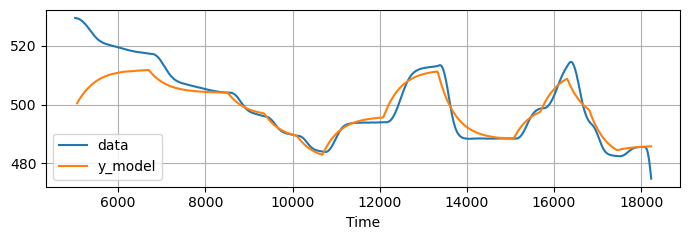

In [10]:
plt.figure(figsize=(7, 2.5))
plt.plot(t, input_output_data["Output"].to_numpy(), label='data')
plt.plot(t, y_model, label='y_model')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
%%time

y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)

CPU times: user 17 μs, sys: 0 ns, total: 17 μs
Wall time: 18.8 μs


## Construct Optimization Cost Function

In [12]:
def function_to_minimize(x):
    K = x[0]
    tau = x[1]
    n_delay = x[2] if isinstance(x[2], int) else int(x[2] / dt + 0.5)
    y_base = x[3]
    u_base = x[4]
    y_init = x[5]
    y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)
    ssd = prediction_error(y_model[n_delay+1:], y_data[n_delay+1:])
    return ssd


x = [K, tau, n_delay, y_base, u_base, y_init]
ssd = function_to_minimize(x)
ssd

np.float64(27352.792889210206)

In [13]:
# Alternatively provide theta instead of n_delay
theta = n_delay * dt
x = [K, tau, theta, y_base, u_base, y_init]
assert np.isclose(function_to_minimize(x), ssd)

In [14]:
# Set parameter bounds based on data characteristics
y_mean = input_output_data['Output'].mean()
y_range = input_output_data['Output'].max() - input_output_data['Output'].min()

u_mean = input_output_data[input_col].mean()
u_range = input_output_data[input_col].max() - input_output_data[input_col].min()

time_span = input_output_data['Time'].max() - input_output_data['Time'].min()

# Intelligent parameter bounds
# Make sure these are in the same order as elements of x
bounds = {
    'K': (-5 * y_range / u_range, 5 * y_range / u_range),   # Process gain
    'tau': (dt, time_span / 3),                             # Time constant
    'theta': (0.0, time_span / 10),                         # Dead time
    'y_base': (y_mean - 2 * y_range, y_mean + 2 * y_range), # Output baseline
    'u_base': (u_mean - 2 * u_range, u_mean + 2 * u_range), # Input baseline
    'y_init': (                                          # Initial output
        input_output_data['Output'].iloc[0] - y_range, 
        input_output_data['Output'].iloc[0] + y_range
    ),
    #'mystery_del_t': (-0.1, 0.1)                            # Empirical correction
}
var_names = list(bounds.keys())
bounds = list(bounds.values())
bounds

[(np.float64(-85.37499999999989), np.float64(85.37499999999989)),
 (np.float64(15.02181818181818), np.float64(4406.4)),
 (0.0, np.float64(1321.9199999999998)),
 (np.float64(390.72511918274705), np.float64(609.2851191827467)),
 (np.float64(-1.1950056753688987), np.float64(11.604994324631102)),
 (np.float64(474.79), np.float64(584.0699999999999))]

Solution:
K          -11.438583
tau       4406.400000
theta        7.510907
y_base     416.289243
u_base      11.604994
y_init     518.337824
dtype: float64


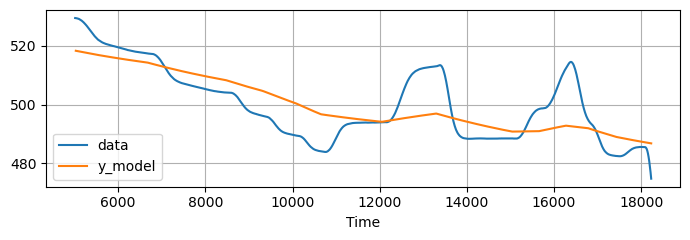

CPU times: user 345 ms, sys: 5.4 ms, total: 350 ms
Wall time: 350 ms


In [36]:
%%time

# Run Leapfrog optimizer
sol = lpfgopt.minimize(function_to_minimize, bounds)
assert sol.status == 0
print(f"Solution:\n{pd.Series({name: x for name, x in zip(var_names, sol['x'])})}")

K, tau, theta, y_base, u_base, y_init = sol['x']
n_delay = int(theta / dt + 0.5)
y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)

plt.figure(figsize=(7, 2.5))
plt.plot(t, input_output_data["Output"].to_numpy(), label='data')
plt.plot(t, y_model, label='y_model')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Check repeatability

In [ ]:
from collections import Counter

solutions = []
for _ in range(10):
    sol = lpfgopt.minimize(function_to_minimize, bounds)
    solutions.append(np.concatenate([sol['x'],[sol['fun']]]))
solutions = np.stack(solutions)

pd.DataFrame(solutions, columns=var_names +['fun']).round(3)

,K,tau,theta,y_base,u_base,y_init,fun
0,-12.250,443.053,56.292,477.937,6.853,533.770,4607.505
1,-12.584,524.808,0.000,578.560,-1.195,533.413,5203.026
2,15.900,2668.744,1321.920,390.725,-1.195,526.781,34606.826
3,35.127,4406.400,1321.920,606.167,8.518,527.928,30418.729
4,-12.584,524.808,0.031,478.828,6.730,533.413,5203.026
5,18.400,3144.073,1189.489,609.285,11.605,527.006,35663.830
6,35.127,4406.400,1321.920,428.139,3.450,527.928,30418.729
7,-12.420,484.065,22.573,478.238,6.802,533.590,4863.055
8,-12.584,524.811,0.000,578.560,-1.195,533.413,5203.026
9,35.127,4406.400,1321.920,390.725,2.385,527.928,30418.729
